### Libraries

In [1]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

### Load Data

In [2]:
df = pd.read_csv('Query_AI_text_clean.csv')

In [3]:
df.head(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,203.896104,421.675325,-1,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,276.623377,556.571429,-1,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,141.558442,608.454545,p_2,useful robot need lazy useful robot need lazy ...


### Temperature

In [4]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
439,I just watched Biggie Smalls perform ‘live’ in...,https://www.technologyreview.com/2022/12/16/10...,2022,I just watched Biggie Smalls perform ‘live’ in...,"['Coachella', 'Miles Davis', 'Osagie', 'Reming...",0,#aa0055,390.909091,297.155844,n_1,watch biggie smalls perform live metaverse wat...
511,"Modern data management, the hidden brain of AI",https://www.technologyreview.com/2022/04/28/10...,2022,Sponsored\nProvided byDell\nArtificial intelli...,"['Robin Hanson', 'Kevin Simler', 'MIT Technolo...",0,#aa0055,494.805195,400.922078,n_1,modern datum management hidden brain sponsored...
253,We need to focus on the AI harms that already ...,https://www.technologyreview.com/2023/10/30/10...,2023,We need to focus on the AI harms that already ...,"['Alexa', 'New York University', 'Google', 'Op...",1,#5500aa,422.077922,307.532468,p_11,need focus harm exist need focus harm exist fe...


In [5]:
df.columns

Index(['title', 'url', 'year', 'text', 'entities', 'temperature', 'color', 'x',
       'y', 'cluster', 'clean_text'],
      dtype='object')

### Term Frequency

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["clean_text"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

In [7]:
df.head(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,203.896104,421.675325,-1,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,276.623377,556.571429,-1,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,141.558442,608.454545,p_2,useful robot need lazy useful robot need lazy ...


## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


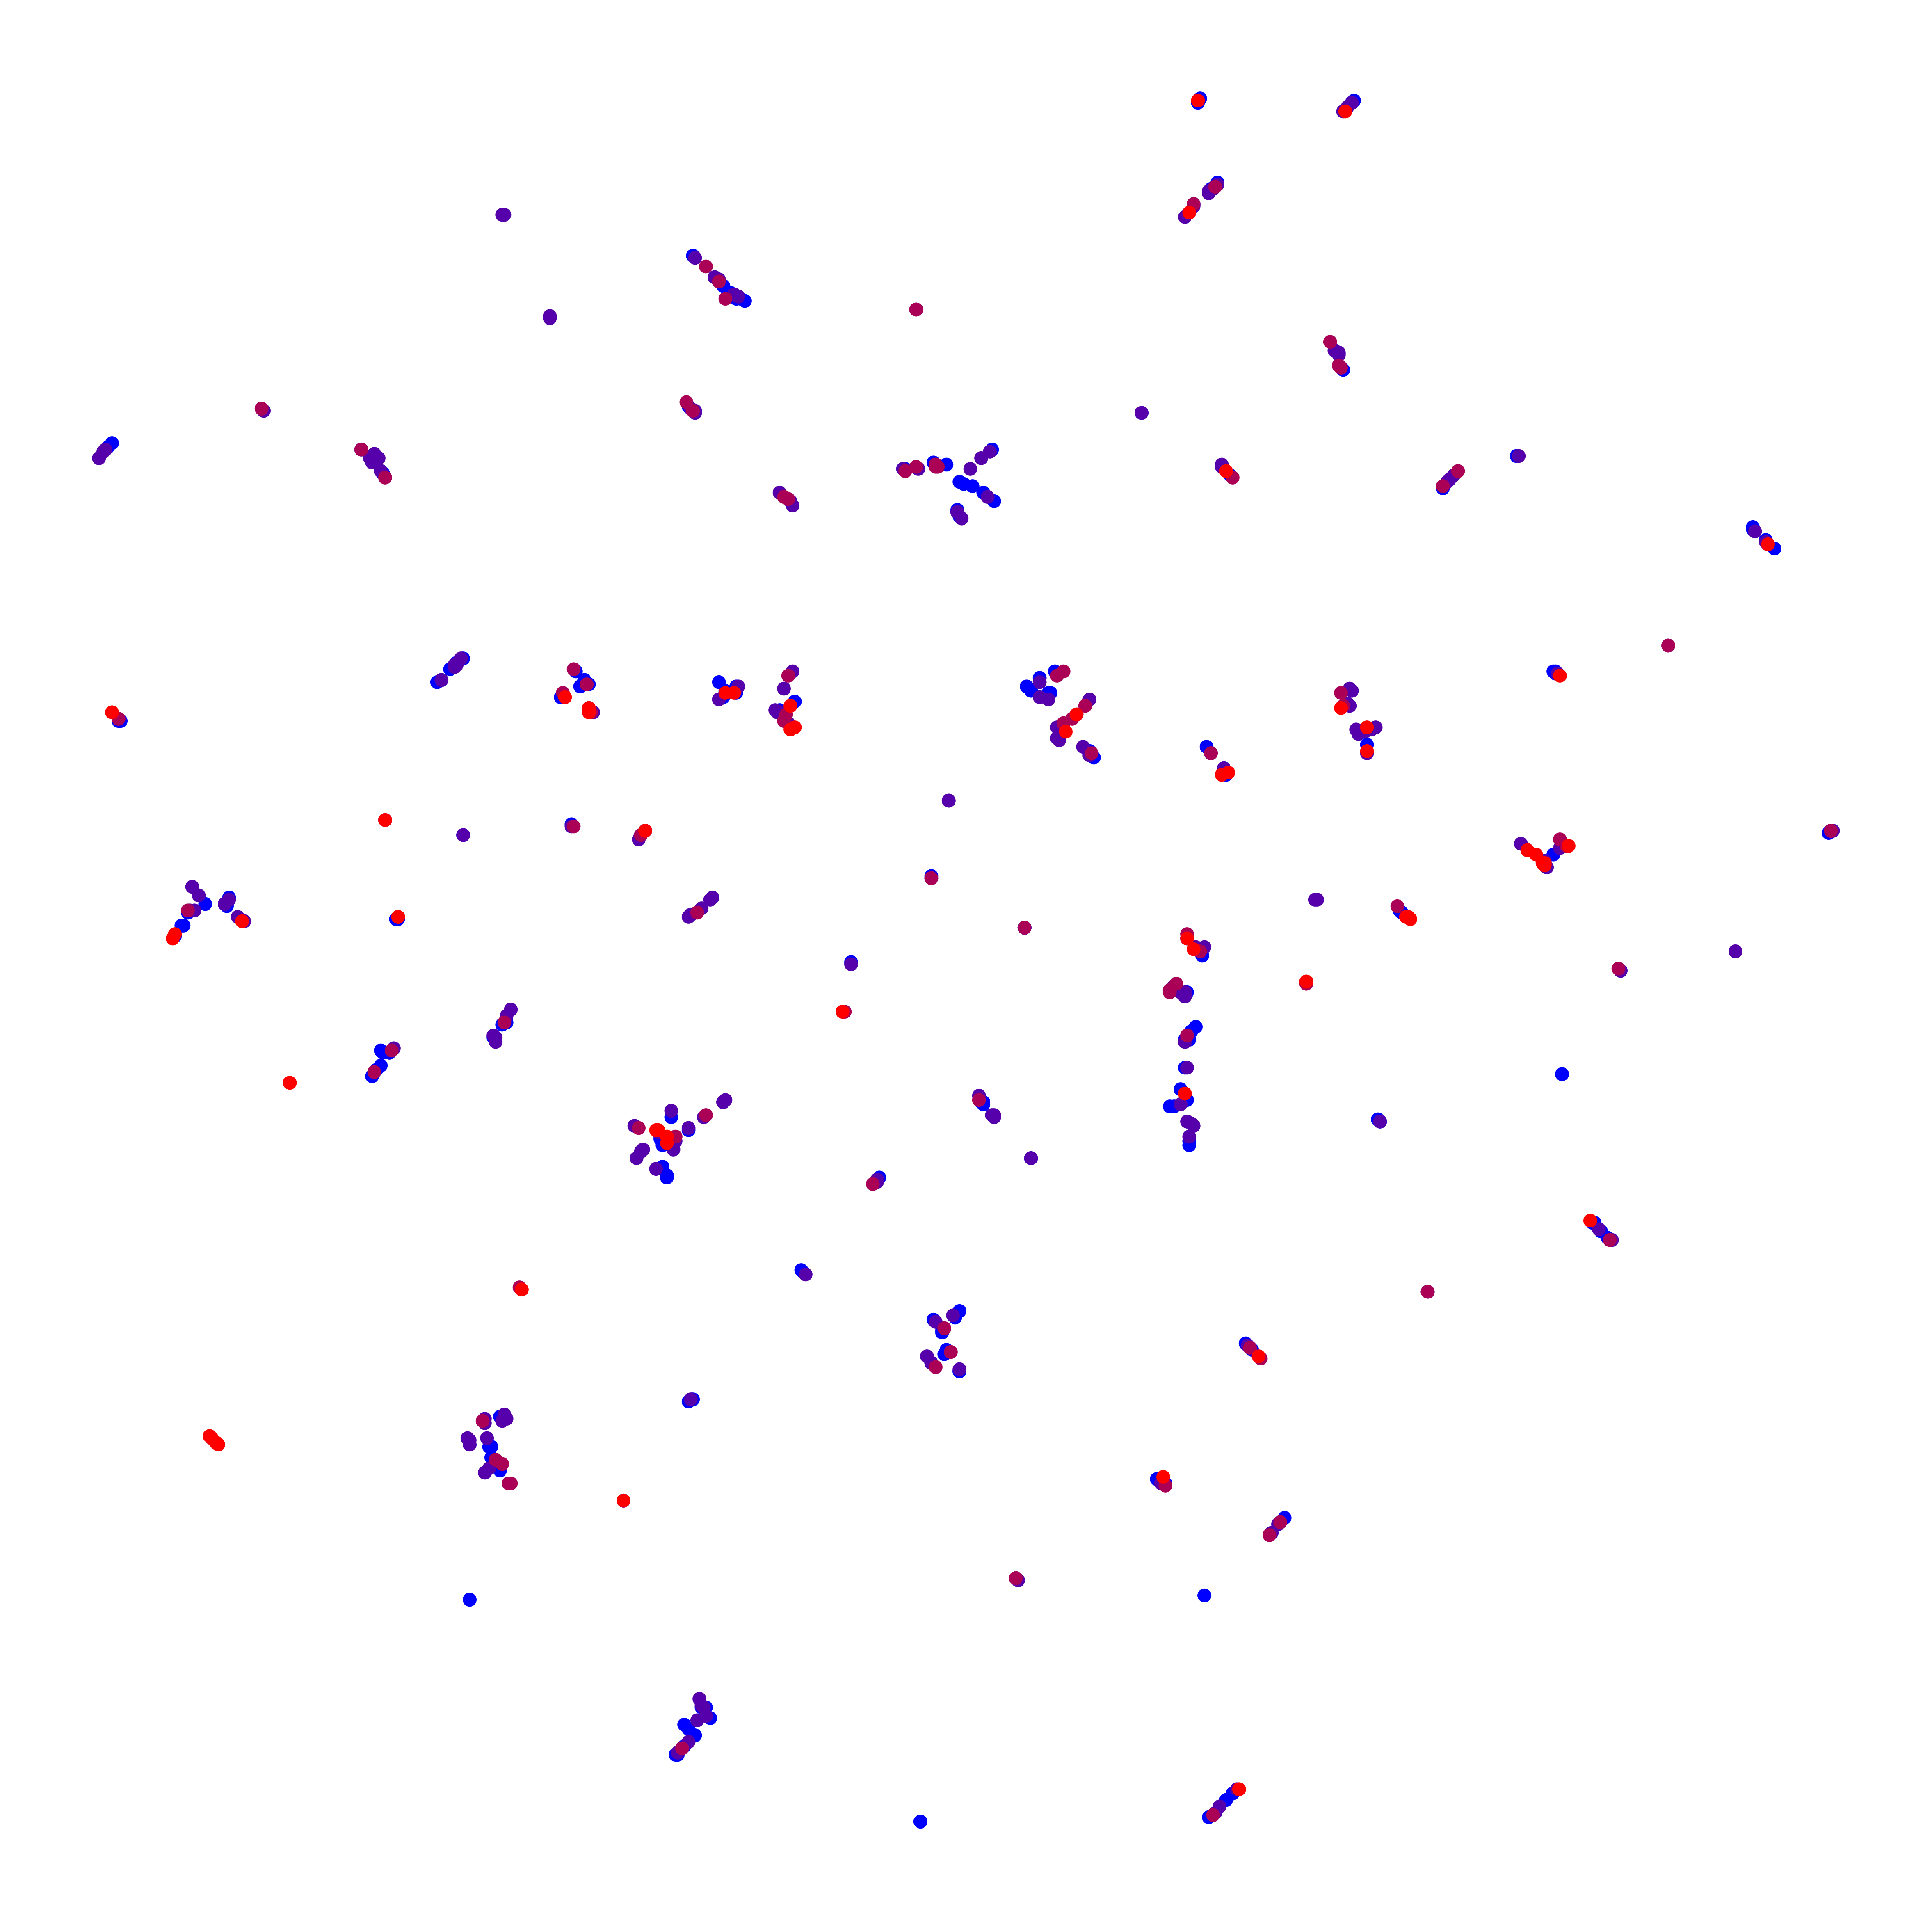

In [45]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=1,
    n_components=2,
    n_neighbors=2,
    min_dist=0.2,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

# embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")


In [46]:
df.head(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,141.0,522.0,p_7,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,495.0,334.0,p_31,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,616.0,861.0,p_12,useful robot need lazy useful robot need lazy ...


## Clustering

In [49]:
clusterer = hdbscan.HDBSCAN(
    min_samples=3,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=6,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
200,How AI is changing gymnastics judging,https://www.technologyreview.com/2024/01/16/10...,2024,How AI is changing gymnastics judging\nPropone...,"['National Geographic', 'Kaia Tanskanen', 'US'...",2,#0000ff,599.0,440.0,p_20,change gymnastic judging change gymnastic judg...
216,Yahoo’s decades-long China controversy and the...,https://www.technologyreview.com/2023/12/13/10...,2023,Yahoo’s decades-long China controversy and the...,"['Commerce', 'US', 'IPO', 'NYC', 'New York Tim...",1,#5500aa,606.0,506.0,p_20,yahoo decade long china controversy responsibi...
455,A bias bounty for AI will help to catch unfair...,https://www.technologyreview.com/2022/10/20/10...,2022,A bias bounty for AI will help to catch unfair...,"['Splunk', 'Abhishek Gupta', 'Deborah Raji', '...",0,#aa0055,366.0,418.0,n_6,bias bounty help catch unfair algorithm fast b...


{'p_27', 'n_10', 'n_11', 'n_1', 'p_23', 'p_6', 'p_21', 'n_2', 'p_29', 'p_31', 'n_7', 'p_12', 'p_3', 'p_30', 'p_26', 'p_16', 'p_4', 'p_24', 'p_2', 'p_11', 'p_28', 'n_3', 'p_9', 'p_8', 'p_20', 'p_18', 'n_8', 'p_10', 'p_22', 'n_9', 'p_15', 'n_5', 'p_0', 'p_7', 'n_0', 'p_1', 'p_17', '-1', 'p_14', 'n_4', 'p_5', 'p_25', 'p_19', 'p_13', 'n_6'}


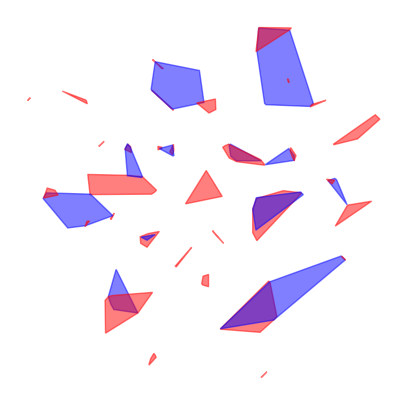

In [50]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [51]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
561,"China’s path to modernization has, for centuri...",https://www.technologyreview.com/2021/06/30/10...,2021,"China’s path to modernization has, for centuri...","['the United States', 'the Jiangnan Arsenal', ...",-1,#ff0000,607.0,899.0,n_1,china path modernization century go hometown c...


In [55]:
# Group by cluster
grouped = df.groupby('cluster')

# Iterate through each cluster and randomly select 10 titles
random_titles_per_cluster = {}

for cluster, group in grouped:
    # Randomly sample 10 titles (or all titles if less than 10)
    sampled_titles = group['title'].sample(n=min(20, len(group)), random_state=1).tolist()
    random_titles_per_cluster[cluster] = sampled_titles

# # Display the result
# for cluster, titles in random_titles_per_cluster.items():
#     print(f"Cluster: {cluster}")
#     for title in titles:
#         print(f"- {title}")

random_titles_per_cluster['p_3']

['Digital technology: The backbone of a net-zero emissions future',
 'Integrating sustainability into business strategy',
 'Decarbonizing production of energy is a quick win',
 'Google, Amazon and the problem with Big Tech’s climate claims',
 'The UAE’s transition to a net-zero future',
 'Our quick guide to the 6 ways we can regulate AI',
 'Rethinking sustainable mobility in a new, digital landscape']